# XU Method – Entropy-Based Anomaly Detection on CTU-13

Ce Notebook démontre l'approche XU, basée sur l'entropie, sur un dataset de type CTU-13.

### Étapes principales :
1. Import & Setup
2. Chargement de données (fichier binetflow)
3. Préprocessing (simplification des labels)
4. **Fonction `XU_algorithm`** qui calcule l'entropie par IP source
5. Application de la fonction XU et visualisation des résultats
6. Évaluation (matrice de confusion, précision, rappel, etc.)


## 1. Import & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
sns.set()
print("Libraries loaded.")

Libraries loaded.


## 2. Chargement de données
Nous supposons que vous avez déjà un fichier `.binetflow` extrait de CTU-13 (e.g. scenario 5).

In [47]:
import re

# Chemin du fichier d'origine
input_file = 'dataset\capture20110817.pcap.netflow.labeled'
# Chemin du fichier de sortie
output_file = 'dataset\capture20110817.pcap.netflow.labeled.csv'

with open(input_file, 'r', encoding='utf-8', errors='replace') as f:
    lines = f.readlines()

# Pour chaque ligne, remplace tous les groupes d'espaces par une virgule
converted_lines = [re.sub(r'\s+', ',', line.strip()) for line in lines]

# Écrit le résultat dans un nouveau fichier
with open(output_file, 'w', encoding='utf-8') as f:
    for line in converted_lines:
        f.write(line + "\n")

print("Fichier converti en CSV sauvegardé sous", output_file)


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kira\AppData\Local\Temp\ipykernel_17320\3106659421.py:4: SyntaxWarning: invalid escape sequence '\c'
  input_file = 'dataset\capture20110817.pcap.netflow.labeled'
C:\Users\kira\AppData\Local\Temp\ipykernel_17320\3106659421.py:6: SyntaxWarning: invalid escape sequence '\c'
  output_file = 'dataset\capture20110817.pcap.netflow.labeled.csv'


Fichier converti en CSV sauvegardé sous dataset\capture20110817.pcap.netflow.labeled.csv


In [132]:
# Chemin vers un fichier .binetflow
data_path = "dataset\capture20110817.pcap.netflow.labeled.csv"

df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
print(f"Data shape: {df.shape}")
df.head(20)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kira\AppData\Local\Temp\ipykernel_17320\1584984224.py:2: SyntaxWarning: invalid escape sequence '\c'
  data_path = "dataset\capture20110817.pcap.netflow.labeled.csv"


Data shape: (8079338, 13)


,Date,flow_start,Durat,Prot,SrcIPAddr:Port,Direc,DstIPAddr:Port,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-17,12:01:01.780,3.124,UDP,188.75.133.98:16200,->,147.32.86.125:35248,INT,0,304,219158,1,Background
1,2011-08-17,12:01:01.782,4.922,TCP,119.252.172.92:59067,->,147.32.84.14:80,A_,0,39,2346,1,Background
2,2011-08-17,12:01:01.783,1.000,TCP,90.183.101.168:80,->,147.32.86.89:1176,FPA_,0,4,2905,1,Background
3,2011-08-17,12:01:01.783,4.996,TCP,217.169.177.82:56950,->,147.32.85.26:54145,PA_,0,433,27648,1,Background
4,2011-08-17,12:01:01.784,4.986,TCP,147.32.85.26:54145,->,217.169.177.82:56950,PA_,0,837,1173304,1,Background
5,2011-08-17,12:01:01.784,4.874,TCP,119.252.172.92:59066,->,147.32.84.14:80,A_,0,163,9990,1,Background
6,2011-08-17,12:01:01.784,0.000,TCP,89.185.253.133:443,->,147.32.86.107:51505,FPA_,0,3,455,1,Background
7,2011-08-17,12:01:01.784,4.874,TCP,147.32.84.14:80,->,119.252.172.92:59066,PA_,0,483,731262,1,Background
8,2011-08-17,12:01:01.785,0.998,TCP,147.32.86.89:1176,->,90.183.101.168:80,A_,0,2,120,1,Background
9,2011-08-17,12:01:01.785,0.000,TCP,147.32.86.107:51505,->,89.185.253.133:443,RPA_,0,2,151,1,Background


## 3. Préprocessing / Data Exploration
On convertit les labels (Botnet vs Normal).

In [133]:
def separate_ports(df):
    """
    Sépare les informations d'IP et de port pour les colonnes 'SrcIPAddr:Port' et 'DstIPAddr:Port'.
    
    La fonction fait :
    - La séparation en deux colonnes pour chacune des colonnes concernées.
    - La suppression des colonnes d'origine.
    - La réorganisation des colonnes afin que les deux nouvelles colonnes remplacent la colonne d'origine
      (les ports se retrouvent à droite de leur adresse IP).
    
    Retourne le DataFrame modifié.
    """
    # Effectuer la séparation pour la source
    src_split = df["SrcIPAddr:Port"].str.split(":", expand=True)
    df["SrcIP"] = src_split[0]
    df["SrcPort"] = src_split[1]
    
    # Effectuer la séparation pour la destination
    dst_split = df["DstIPAddr:Port"].str.split(":", expand=True)
    df["DstIP"] = dst_split[0]
    df["DstPort"] = dst_split[1]
    
    # Sauvegarder l'ordre original connu
    original_cols = ["Date", "flow_start", "Durat", "Prot", 
                     "SrcIPAddr:Port", "Direc", "DstIPAddr:Port", 
                     "Flags", "Tos", "Packets", "Bytes", "Flows", "Label"]
    
    # Trouver les positions des colonnes à remplacer
    src_idx = original_cols.index("SrcIPAddr:Port")
    dst_idx = original_cols.index("DstIPAddr:Port")
    
    # Construire le nouvel ordre des colonnes :
    # - Conserver les colonnes avant la colonne source d'origine.
    new_order = original_cols[:src_idx]
    # - Remplacer "SrcIPAddr:Port" par "SrcIP" et "SrcPort"
    new_order.extend(["SrcIP", "SrcPort"])
    # - Conserver les colonnes entre la colonne source et la colonne destination d'origine
    new_order.extend(original_cols[src_idx+1:dst_idx])
    # - Remplacer "DstIPAddr:Port" par "DstIP" et "DstPort"
    new_order.extend(["DstIP", "DstPort"])
    # - Conserver le reste des colonnes après la colonne destination d'origine
    new_order.extend(original_cols[dst_idx+1:])
    
    # Supprimer les colonnes d'origine
    df = df.drop(columns=["SrcIPAddr:Port", "DstIPAddr:Port"])
    
    # Réorganiser le DataFrame selon le nouvel ordre
    df = df[new_order]
    
    return df

In [134]:
df = separate_ports(df)
df.head(10)

,Date,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-17,12:01:01.780,3.124,UDP,188.75.133.98,16200,->,147.32.86.125,35248,INT,0,304,219158,1,Background
1,2011-08-17,12:01:01.782,4.922,TCP,119.252.172.92,59067,->,147.32.84.14,80,A_,0,39,2346,1,Background
2,2011-08-17,12:01:01.783,1.000,TCP,90.183.101.168,80,->,147.32.86.89,1176,FPA_,0,4,2905,1,Background
3,2011-08-17,12:01:01.783,4.996,TCP,217.169.177.82,56950,->,147.32.85.26,54145,PA_,0,433,27648,1,Background
4,2011-08-17,12:01:01.784,4.986,TCP,147.32.85.26,54145,->,217.169.177.82,56950,PA_,0,837,1173304,1,Background
5,2011-08-17,12:01:01.784,4.874,TCP,119.252.172.92,59066,->,147.32.84.14,80,A_,0,163,9990,1,Background
6,2011-08-17,12:01:01.784,0.000,TCP,89.185.253.133,443,->,147.32.86.107,51505,FPA_,0,3,455,1,Background
7,2011-08-17,12:01:01.784,4.874,TCP,147.32.84.14,80,->,119.252.172.92,59066,PA_,0,483,731262,1,Background
8,2011-08-17,12:01:01.785,0.998,TCP,147.32.86.89,1176,->,90.183.101.168,80,A_,0,2,120,1,Background
9,2011-08-17,12:01:01.785,0.000,TCP,147.32.86.107,51505,->,89.185.253.133,443,RPA_,0,2,151,1,Background


In [136]:
def hist_of_label_values(df):
    """
    Affiche un histogramme de la répartition des labels dans le DataFrame,
    avec les pourcentages affichés sur les barres.
    
    Paramètres :
    - df : pd.DataFrame contenant une colonne 'Label' avec les valeurs 
           'Background', 'Normal' et 'Botnet'.
    
    Affichage :
    - Un histogramme avec les pourcentages sur les barres.
    - Un dictionnaire affiché contenant les pourcentages.
    """
    # Regroupement des valeurs
    label_values = df['Label'].value_counts()

    # Somme des catégories
    background_count = sum(label_values[label] for label in label_values.index if "Background" in label)
    normal_count = sum(label_values[label] for label in label_values.index if "LEGITIMATE" in label)
    botnet_count = sum(label_values[label] for label in label_values.index if "Botnet" in label)
    
    # Dictionnaire des comptages
    label_repartition = {
        "Background traffic": background_count, 
        "Normal traffic": normal_count, 
        "Botnet traffic": botnet_count
    }

    # Calcul du total et des pourcentages
    total_traffic = sum(label_repartition.values())
    percentage_of_traffic = {k: round((v / total_traffic) * 100, 2) for k, v in label_repartition.items()}

    # Affichage de l'histogramme
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(label_repartition.keys(), label_repartition.values(), color=['gray', 'blue', 'red'])

    # Ajout des pourcentages au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_traffic) * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + total_traffic * 0.02, 
                f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    # Amélioration du visuel
    ax.set_ylabel("Nombre de flux", fontsize=12)
    ax.set_title("Répartition du trafic par catégorie", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


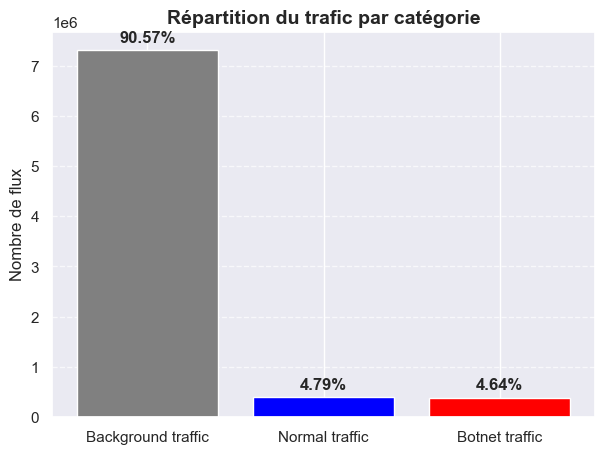

In [137]:
hist_of_label_values(df)

In [138]:
pd.DataFrame(df[df["Label"] == "Botnet"]["SrcIP"].value_counts()).head(20)

,count
SrcIP,
147.32.80.9,108534
147.32.84.165,28677
147.32.84.192,24873
147.32.84.191,23344
147.32.84.204,23197
147.32.84.206,23126
147.32.84.193,22775
147.32.84.205,22289
147.32.84.208,22258


## 4. Fonction `XU_algorithm`
Cette fonction va :
1. Agréger par IP source.
2. Calculer l'entropie normalisée (ports source, ports destination, IP destination).
3. Calculer le score `score = H(DstIP) - H(DstPort)`.
4. Déterminer un seuil via le quantile (par défaut 95ᵉ percentile).
5. Retourner un DataFrame par IP avec colonnes d'entropie, le score, la prédiction, etc.

In [139]:
def XU_algorithm(df_binetflow, threshold=0.5):
    """
    Implémente l'algorithme XU basé sur la distance entropique moyenne entre deux profils de référence :
    - Serveur typique : [0.2, 0.9, 0.5]
    - Client lourd : [0.9, 0.2, 0.2]

    Paramètres :
    - df_binetflow : DataFrame contenant au moins les colonnes 'SrcAddr', 'Sport', 'Dport', 'DstAddr', 'Label'
    - threshold : seuil de classification sur la distance moyenne

    Retour :
    - df_features : DataFrame avec :
        - RU calculées par source IP
        - Distances aux deux profils de référence
        - Moyenne des distances
        - Score d'anomalie et classification
    """

    def normalized_entropy(series):
        counts = series.value_counts(normalize=True, dropna=False)
        entropy = -(counts * np.log2(counts + 1e-12)).sum()
        distinct = len(counts)
        total_samples = len(series)
        if distinct <= 1 or total_samples <= 1:
            return 0.0
        max_entropy = np.log2(min(distinct, total_samples))
        return float(entropy / max_entropy)

    grouped = df_binetflow.groupby('SrcIP')
    rows = []

    for src_ip, group in grouped:
        ru_srcport = normalized_entropy(group['SrcPort'].fillna('N/A'))
        ru_dstport = normalized_entropy(group['DstPort'].fillna('N/A'))
        ru_dstip = normalized_entropy(group['DstIP'].fillna('N/A'))
        labels = group['Label'].unique()
        label = 'Botnet' if 'Botnet' in labels else 'Normal'
        rows.append({
            'SrcIP': src_ip,
            'RU_SrcPort': ru_srcport,
            'RU_DstPort': ru_dstport,
            'RU_DstIP': ru_dstip,
            'Label': label
        })

    df_features = pd.DataFrame(rows)

    # Profils de référence
    ref_server = np.array([0.2, 0.9, 0.5])
    ref_client = np.array([0.9, 0.2, 0.2])
    ref_zero = np.zeros(3)

    # Calcul des distances
    df_features['Distance_Server'] = np.sqrt(
        (df_features['RU_SrcPort'] - ref_server[0]) ** 2 +
        (df_features['RU_DstPort'] - ref_server[1]) ** 2 +
        (df_features['RU_DstIP'] - ref_server[2]) ** 2
    )

    df_features['Distance_Client'] = np.sqrt(
        (df_features['RU_SrcPort'] - ref_client[0]) ** 2 +
        (df_features['RU_DstPort'] - ref_client[1]) ** 2 +
        (df_features['RU_DstIP'] - ref_client[2]) ** 2
    )

    df_features['Distance_Zero'] = np.sqrt(
        (df_features['RU_SrcPort'] - ref_zero[0]) ** 2 +
        (df_features['RU_DstPort'] - ref_zero[1]) ** 2 +
        (df_features['RU_DstIP'] - ref_zero[2]) ** 2
    )

    df_features['Mean_Distance'] = (df_features['Distance_Server'] + df_features['Distance_Client'] + df_features["Distance_Zero"]) / 3
    df_features['AnomalyScore'] = df_features['Mean_Distance']
    df_features['Predicted'] = df_features['AnomalyScore'].apply(lambda d: 'Botnet' if d > threshold else 'Normal')

    return df_features


## 5. Application
On applique `XU_algorithm` à notre DataFrame `df`, puis on regarde le résultat.

In [140]:
df_features = XU_algorithm(df, threshold=1.0)
df_features.head(10)

,SrcIP,RU_SrcPort,RU_DstPort,RU_DstIP,Label,Distance_Server,Distance_Client,Distance_Zero,Mean_Distance,AnomalyScore,Predicted
0,,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
1,0,0.064207,0.048016,0.048016,Normal,0.973964,0.862988,0.093454,0.643469,0.643469,Normal
2,0.0.0.0,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
3,1.112.101.248,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
4,1.112.110.245,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
5,1.112.13.27,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
6,1.112.141.53,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
7,1.112.141.91,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
8,1.112.147.98,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal
9,1.112.159.126,0.000000,0.000000,0.000000,Normal,1.048809,0.943398,0.000000,0.664069,0.664069,Normal


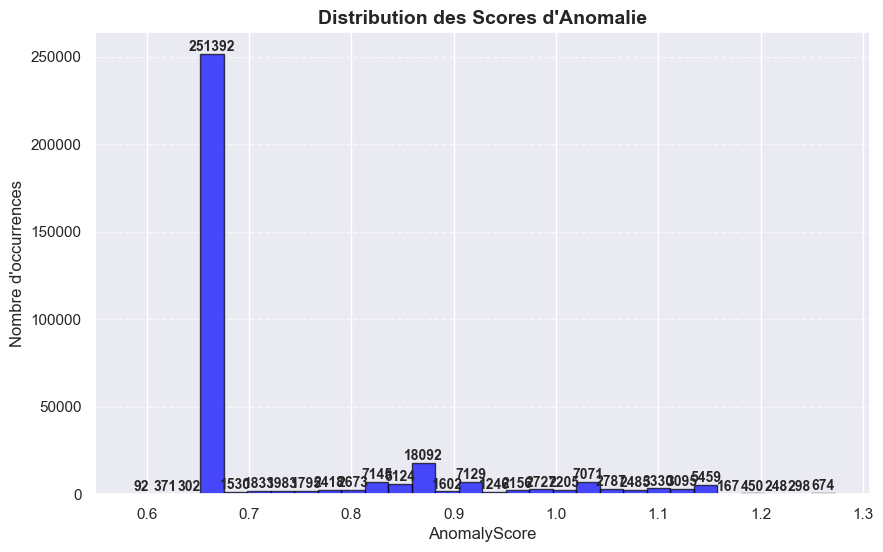

In [141]:
def plot_anomaly_score_histogram_with_counts(df_features):
    """
    Affiche un histogramme de la distribution des scores d'anomalie (AnomalyScore) 
    avec les nombres d'occurrences affichés sur chaque barre.

    Paramètre :
    - df_features : DataFrame contenant une colonne 'AnomalyScore'.

    Affichage :
    - Un histogramme montrant la répartition des scores d'anomalie avec les effectifs sur les barres.
    """

    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(df_features['AnomalyScore'], bins=30, color='blue', edgecolor='black', alpha=0.7)

    # Ajouter les étiquettes de fréquence au-dessus des barres
    for count, bin_patch in zip(counts, patches):
        if count > 0:  # Éviter d'afficher les valeurs nulles
            plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count, 
                     f"{int(count)}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Distribution des Scores d\'Anomalie', fontsize=14, fontweight='bold')
    plt.xlabel('AnomalyScore', fontsize=12)
    plt.ylabel('Nombre d\'occurrences', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

plot_anomaly_score_histogram_with_counts(df_features)


In [142]:
def display_botnet_anomaly_scores(df_features):
    """
    Affiche les scores d'anomalie des adresses IP taguées comme Botnet sous forme de tableau.

    Paramètre :
    - df_features : DataFrame contenant les colonnes 'SrcAddr', 'AnomalyScore' et 'Label'.

    Affichage :
    - Un tableau des adresses IP Botnet avec leurs scores d'anomalie.
    """

    # Filtrer uniquement les adresses taguées comme Botnet
    botnet_scores_df = df_features[df_features['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)

    return botnet_scores_df

botnet_scores_df = display_botnet_anomaly_scores(df_features)
botnet_scores_df

,SrcIP,AnomalyScore
0,109.107.241.175,1.093793
1,109.207.207.193,0.664069
2,109.87.137.226,1.135873
3,109.99.150.74,1.089821
4,110.171.28.154,1.088254
...,...,...
694,98.136.185.95,1.112272
695,98.138.84.55,1.135873
696,98.139.212.139,1.135873
697,98.154.76.79,1.116616


## 6. Évaluation
On compare la prédiction par IP (`Predicted`) avec le label vrai (`Label`), puis on calcule éventuellement la matrice de confusion au **niveau IP**. Après, on peut mapper cette prédiction sur chaque flux si on le souhaite (host → flows).

In [143]:
def display_confusion_matrix(y_true, y_pred):
    """
    Affiche un tableau structuré avec les métriques de classification :
    TP, TN, FP, FN et le rapport de classification détaillé.

    Paramètres :
    - y_true : Liste des vraies étiquettes (Normal/Botnet)
    - y_pred : Liste des prédictions du modèle (Normal/Botnet)
    """
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=['Normal', 'Botnet'])
    print(cm)
    # Extraction des valeurs TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    
    # Création d'un DataFrame pour afficher sous forme de tableau 2x2
    confusion_df = pd.DataFrame(
        [[f"TN: {tn}", f"FP: {fp}"],
         [f"FN: {fn}", f"TP: {tp}"]],
        index=["Actual Normal", "Actual Botnet"],
        columns=["Predicted Normal", "Predicted Botnet"]
    )

    # Affichage du tableau
    print("\n📊 **Matrice de Confusion & Résumé des métriques**")
    display(confusion_df)
    
    # Génération du rapport de classification
    classification_rep = classification_report(y_true, y_pred, labels=['Normal', 'Botnet'], output_dict=True)
    classification_df = pd.DataFrame(classification_rep).transpose()

    # Affichage du rapport détaillé
    print("\n📑 **Rapport de Classification**")
    display(classification_df)


In [145]:
y_true = df_features['Label']
y_pred = df_features['Predicted']

display_confusion_matrix(y_true, y_pred)

[[310823  27357]
 [   239    460]]

📊 **Matrice de Confusion & Résumé des métriques**


,Predicted Normal,Predicted Botnet
Actual Normal,TN: 310823,FP: 27357
Actual Botnet,FN: 239,TP: 460



📑 **Rapport de Classification**


,precision,recall,f1-score,support
Normal,0.999232,0.919105,0.957495,338180.000000
Botnet,0.016537,0.658083,0.032263,699.000000
accuracy,0.918567,0.918567,0.918567,0.918567
macro avg,0.507884,0.788594,0.494879,338879.000000
weighted avg,0.997205,0.918567,0.955587,338879.000000


### Flow-level metrics
Si l'on veut évaluer plus finement au niveau **flow** :
1. Merge `df_features` dans `df` sur la colonne `SrcAddr`.
2. Si un IP est classé Botnet, tous ses flux deviennent Botnet.
3. On compare `df['Label']` et `df['PredictedFlow']`.

In [124]:
# 1. Merge
df_merged = df.merge(df_features[['SrcIP','Predicted']], on='SrcIP', how='left')
df_merged['PredictedFlow'] = df_merged['Predicted']

# 2. On compare
y_true_fl = df_merged['Label']
y_pred_fl = df_merged['PredictedFlow']

cm_fl = confusion_matrix(y_true_fl, y_pred_fl, labels=['Normal','Botnet'])
tn, fp, fn, tp = cm_fl.ravel()

print("Matrice de confusion (Flow-level) :")
print(cm_fl)
print(classification_report(y_true_fl, y_pred_fl, labels=['Normal','Botnet']))

Matrice de confusion (Flow-level) :
[[     0      0]
 [374468    577]]


KeyboardInterrupt: 